# Play with HC02 dataset
- append all the trials for each activity
- features: 10 sec clip, 90% overlap (so 1 sec)
- Perform for each trial then append into df

In [1]:
cd Y:\Inpatient Sensors -Stroke\Data\biostamp_data

Y:\Inpatient Sensors -Stroke\Data\biostamp_data


In [2]:
# Importing the Libraries
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis, pearsonr
from scipy.signal import butter, welch, filtfilt, resample
import time
import re
import copy

In [3]:
if platform.system() == 'Windows':
    if platform.release() == '7':
        path = r'Y:\Inpatient Sensors -Stroke\Data\biostamp_data\controls'
        folder_path = r'Y:\Inpatient Sensors -Stroke\Data\biostamp_data'
        dict_path = r'Y:\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'

In [4]:
# List based on Value data of Activity Recognition
complete= list(['LYING','SITTING','STANDING','WALKING','STAIRS DOWN','STAIRS UP'])

## Extract data without 'trial' structure - NOT completed yet

In [5]:
def process_annotations(path):
#---------------------------------------------------------------------------------------------------------
# Processes raw annotations file to extract start / end timestamps and remove unnecessary data
#
# Inputs:  path - filepath of the subject folder containing annotations.csv
#
# Outputs: df - dataframe containing list of activities and their start / end timestamps
#---------------------------------------------------------------------------------------------------------
    df = pd.read_csv(os.path.join(path, 'annotations.csv'))
    del df['Timestamp (ms)']
    del df['AnnotationId']
    del df['AuthorId']
    
    # subset Activity Recognition data by partially match EventType string
    df = df[df['EventType'].str.match('Activity')]
    del df['EventType']
    df.Value = df.Value.shift(-1)
    df = df.dropna()
    
    # Create Trial column for Value
    sorter = set(df.Value.unique().flatten())
    sorterIndex = dict(zip(sorter, range(len(sorter))))        
    df['Value_Rank'] = df['Value'].map(sorterIndex)
    df['Trial'] = df.groupby('Value')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    del df['Value_Rank']
    df = df.reset_index(drop=True).set_index('Value')
    
    return df

In [ ]:
# Modifying without Trial

#For a given subject, extracts and separates accelerometer, gyroscope, and 
#EMG/ECG data into trials and sensor per activity
def  extract_data(SubID, path):

    ## This is the annotations.csv dataset cleaned
    ## Used to match timestamp ranges to the accel, gyro, elec data
    timestamps = process_annotations(path)
#    timestamps = fix_errors(SubID, timestamps)
#    timestamps = add_unstruct_data(timestamps)
    
    # Creates list of sensor locations from folders within subject's raw data directory
    locations = [locs for locs in os.listdir(path) if os.path.isdir(os.path.join(path, locs))]
    
    # Creates dictionary of empty dataframes to merge all accelerometer, gyroscope, and EMG/ECG data for each sensor
    accel = {locs: pd.DataFrame() for locs in locations}
    gyro = {locs: pd.DataFrame() for locs in locations}
    elec = {locs: pd.DataFrame() for locs in locations}
    
    # Finds and merges all accelerometer, gyroscope, and EMG/ECG data for each sensor, retains datetime information
    for root, dirs, files in os.walk(path, topdown=True):
        for filenames in files:
            if filenames.endswith('accel.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                accel[location] = accel[location].append(temp_df)

            elif filenames.endswith('gyro.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                gyro[location] = gyro[location].append(temp_df)

            elif filenames.endswith('elec.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                elec[location] = elec[location].append(temp_df)
                
    complete_acts = complete
    
    # Complete dictionary of all activities
    act_dict = {acts: pd.DataFrame() for acts in complete_acts}
    
    # Populate dictionary keys per activity with every sensor
    for activities in complete_acts:
        
        startSize = timestamps.loc[activities, 'Start Timestamp (ms)']
        
        if np.size(startSize) == 1:
            startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)']
            endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)']
        else:
            startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)'].values
            endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)'].values

        # Create sensor location dictionary with each key corresponding to sensor locations
        sensor_dict = {locs: pd.DataFrame() for locs in locations}

        # Extract sensor data and populate sensor_dict with sensor data
        for location in locations:
            print(location)#######################################

            data = {'accel': pd.DataFrame(), 'gyro': pd.DataFrame(), 'elec': pd.DataFrame()}

            if not accel[location].empty:
                accelData = accel[location]
                data['accel'] = accelData[(accelData.index >= startTime) & (accelData.index <= endTime)]  
                ###########
                ###########
                #print(bool(data))
                #if not bool(data):
                #    data['accel'] = accelData[(accelData.index >= startTimestamp) & (accelData.index <= endTimestamp)]
                #    print(bool(data))
                #    print('added data') ###########
                #else:
                #    data['accel'] = data['accel'].append(accelData[(accelData.index >= startTimestamp) & (accelData.index <= endTimestamp)])

            if not gyro[location].empty:
                gyroData = gyro[location]
                data['gyro'] = gyroData[(gyroData.index >= startTimestamp) & (gyroData.index <= endTimestamp)]

            if not elec[location].empty:
                elecData = elec[location]
                data['elec'] = elecData[(elecData.index >= startTimestamp) & (elecData.index <= endTimestamp)]

            sensor_dict[location] = data

        act_dict[activities] = sensor_dict
    
    return act_dict, timestamps

In [ ]:
SubID = 'HC02'
timestamps = process_annotations(os.path.join(path, SubID))

In [ ]:
timestamps

## Load HC02 data

In [6]:
#load Pickle file dict
subj = 'HC02'
f = open(os.path.join(dict_path, subj + 'dict.pkl'), 'rb') # use for C: directory
act_dict = pickle.load(f)
f.close()

In [9]:
act_dict['WALKING'][0]['sacrum']['accel'].head(5)

,Accel X (g),Accel Y (g),Accel Z (g)
Timestamp (ms),,,
1510606486688,0.010315,0.925002,0.245182
1510606486720,-0.009461,0.990311,0.212833
1510606486752,0.023865,1.028641,0.190494
1510606486784,0.015198,0.983719,0.186587
1510606486816,-0.083314,0.886671,0.190005


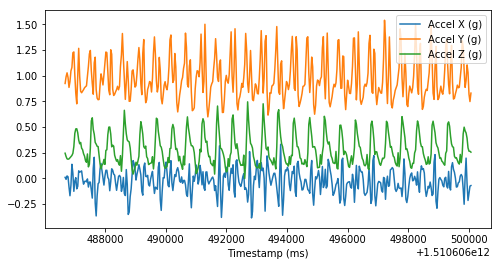

In [8]:
# Plot Sacrum walking
rawdata = act_dict['WALKING'][0]['sacrum']['accel']
rawdata.plot(figsize=(8,4))

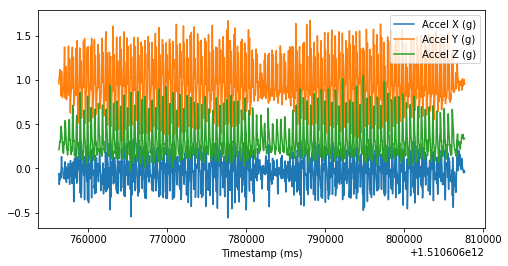

In [10]:
# Plot Sacrum walking
rawdata = act_dict['WALKING'][1]['sacrum']['accel']
rawdata.plot(figsize=(8,4))

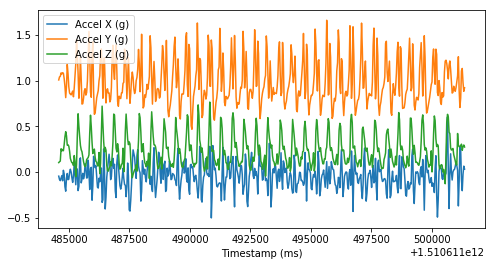

In [11]:
# Plot Sacrum walking
rawdata = act_dict['WALKING'][2]['sacrum']['accel']
rawdata.plot(figsize=(8,4))

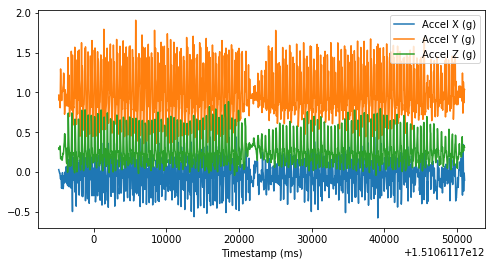

In [12]:
# Plot Sacrum walking
rawdata = act_dict['WALKING'][3]['sacrum']['accel']
rawdata.plot(figsize=(8,4))

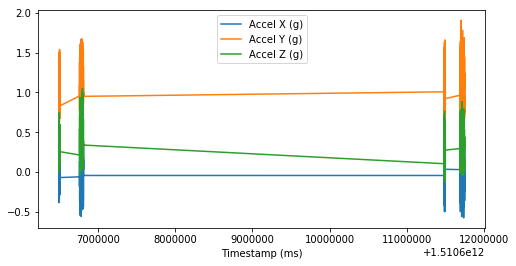

In [13]:
# Plot Sacrum walking - all trials
rawdata = act_dict['WALKING'][0]['sacrum']['accel']
rawdata = rawdata.append(act_dict['WALKING'][1]['sacrum']['accel'])
rawdata = rawdata.append(act_dict['WALKING'][2]['sacrum']['accel'])
rawdata = rawdata.append(act_dict['WALKING'][3]['sacrum']['accel'])
rawdata.plot(figsize=(8,4))

In [ ]:
print(rawdata.head(5))
print(rawdata.tail(5))

## Extract function for graphs

### *** modify gen_clips function to add all trials into one dataset

In [ ]:
#extract clips for accelerometer and gyro data (allows selecting start and end fraction)
#lentol is the % of the intended clipsize below which clip is not used
def gen_clips(act_dict,task,location,clipsize=5000,overlap=0,verbose=False,startTS=0,endTS=1,len_tol=0.8,resample=False):

    clip_data = {} #the dictionary with clips

    for trial in act_dict[task].keys():
#        clip_data[trial] = {}

        for s in ['accel','gyro']:

            if verbose:
                print(task,' sensortype = %s - trial %d'%(s,trial))
            #create clips and store in a list
            rawdata = act_dict[task][trial][location][s]
            if rawdata.empty is True: #skip if no data for current sensor
                continue
            #reindex time (relative to start)
            idx = rawdata.index
            idx = idx-idx[0]
            rawdata.index = idx
            #choose to create clips only on a fraction of the data (0<[startTS,endTS]<1)
            if (startTS > 0) | (endTS < 1):
                rawdata = rawdata.iloc[round(startTS*len(rawdata)):round(endTS*len(rawdata)),:]
                #reindex time (relative to start)
                idx = rawdata.index
                idx = idx-idx[0]
                rawdata.index = idx
            #create clips data
            deltat = np.median(np.diff(rawdata.index))
            clips = []
            #use entire recording
            if clipsize == 0:
                clips.append(rawdata)
            #take clips
            else:
                idx = np.arange(0,rawdata.index[-1],clipsize*(1-overlap))
                for i in idx:
                    c = rawdata[(rawdata.index>=i) & (rawdata.index<i+clipsize)]
                    if len(c) > len_tol*int(clipsize/deltat): #discard clips whose length is less than len_tol% of the window size
                        clips.append(c)

            #store clip length
            clip_len = [clips[c].index[-1]-clips[c].index[0] for c in range(len(clips))] #store the length of each clip
            #assemble in dict
            #clip_data[trial][s] = {'data':clips, 'clip_len':clip_len}
            clip_data[s] = {'data':clips, 'clip_len':clip_len}

    return clip_data

In [ ]:
#extract features from both sensors (accel and gyro) for current clips and trials
#input: dictionary of clips from each subject
#output: feature matrix from all clips from given subject and scores for each clip
def feature_extraction(clip_data):

    features_list = ['RMSX','RMSY','RMSZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ',
                    'skewX','skewY','skewZ','kurtX','kurtY','kurtZ','xcor_peakXY','xcorr_peakXZ','xcorr_peakYZ',
                    'xcorr_lagXY','xcorr_lagXZ','xcorr_lagYZ','Dom_freq','Pdom_rel','PSD_mean','PSD_std','PSD_skew',
                    'PSD_kur','jerk_mean','jerk_std','jerk_skew','jerk_kur','Sen_X','Sen_Y','Sen_Z']

    for trial in clip_data.keys():

        for sensor in clip_data[trial].keys():

            #cycle through all clips for current trial and save dataframe of features for current trial and sensor
            features = []
            for c in range(len(clip_data[trial][sensor]['data'])):
                rawdata = clip_data[trial][sensor]['data'][c]
                #acceleration magnitude
                rawdata_wmag = rawdata.copy()
                rawdata_wmag['Accel_Mag']=np.sqrt((rawdata**2).sum(axis=1))

                #extract features on current clip

                #Root mean square of signal on each axis
                N = len(rawdata)
                RMS = 1/N*np.sqrt(np.asarray(np.sum(rawdata**2,axis=0)))

                #range on each axis
                min_xyz = np.min(rawdata,axis=0)
                max_xyz = np.max(rawdata,axis=0)
                r = np.asarray(max_xyz-min_xyz)

                #Moments on each axis
                mean = np.asarray(np.mean(rawdata,axis=0))
                var = np.asarray(np.std(rawdata,axis=0))
                sk = skew(rawdata)
                kurt = kurtosis(rawdata)

                #Cross-correlation between axes pairs
                xcorr_xy = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,1],mode='same')
                # xcorr_xy = xcorr_xy/np.abs(np.sum(xcorr_xy)) #normalize values
                xcorr_peak_xy = np.max(xcorr_xy)
                xcorr_lag_xy = (np.argmax(xcorr_xy))/len(xcorr_xy) #normalized lag

                xcorr_xz = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,2],mode='same')
                # xcorr_xz = xcorr_xz/np.abs(np.sum(xcorr_xz)) #normalize values
                xcorr_peak_xz = np.max(xcorr_xz)
                xcorr_lag_xz = (np.argmax(xcorr_xz))/len(xcorr_xz)

                xcorr_yz = np.correlate(rawdata.iloc[:,1],rawdata.iloc[:,2],mode='same')
                # xcorr_yz = xcorr_yz/np.abs(np.sum(xcorr_yz)) #normalize values
                xcorr_peak_yz = np.max(xcorr_yz)
                xcorr_lag_yz = (np.argmax(xcorr_yz))/len(xcorr_yz)

                #pack xcorr features
                xcorr_peak = np.array([xcorr_peak_xy,xcorr_peak_xz,xcorr_peak_yz])
                xcorr_lag = np.array([xcorr_lag_xy,xcorr_lag_xz,xcorr_lag_yz])

                #Dominant freq and relative magnitude (on acc magnitude)
                Pxx = power_spectra_welch(rawdata_wmag,fm=0,fM=10)
                domfreq = np.asarray([Pxx.iloc[:,-1].argmax()])
                Pdom_rel = Pxx.loc[domfreq].iloc[:,-1].values/Pxx.iloc[:,-1].sum() #power at dominant freq rel to total

                #moments of PSD
                Pxx_moments = np.array([np.nanmean(Pxx.values),np.nanstd(Pxx.values),skew(Pxx.values),kurtosis(Pxx.values)])

                #moments of jerk magnitude
                jerk = rawdata.iloc[:,-1].diff().values
                jerk_moments = np.array([np.nanmean(jerk),np.nanstd(jerk),skew(jerk[~np.isnan(jerk)]),kurtosis(jerk[~np.isnan(jerk)])])

                #sample entropy raw data (magnitude) and FFT
                sH_raw = []; sH_fft = []

                for a in range(3):
                    x = rawdata.iloc[:,a]
                    n = len(x) #number of samples in clip
                    Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
                    sH_raw.append(nolds.sampen(x)) #samp entr raw data
                    #for now disable SH on fft
                    # f,Pxx_den = welch(x,Fs,nperseg=min(256,n/4))
                    # sH_fft.append(nolds.sampen(Pxx_den)) #samp entr fft

                #Assemble features in array
                X = np.concatenate((RMS,r,mean,var,sk,kurt,xcorr_peak,xcorr_lag,domfreq,Pdom_rel,Pxx_moments,jerk_moments,sH_raw))
                features.append(X)

            F = np.asarray(features) #feature matrix for all clips from current trial
            clip_data[trial][sensor]['features'] = pd.DataFrame(data=F,columns=features_list,dtype='float32')

#     return clip_data #not necessary

## Explore features from individual subject

### ...Skip HC01 until error is fixed

In [91]:
#load Pickle file dict
subj = 'HC02'
f = open(os.path.join(dict_path, subj + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

In [ ]:
# Choose task, sensor location, data type, and trials

#task = 'LYING'
#task = 'SITTING'
#task = 'STANDING'
task = 'WALKING'
#task = 'STAIRS DOWN'
#task = 'STAIRS UP'

#loc = 'bicep_left'
#loc = 'bicep_right'
#loc = 'biceps_femoris_left'
#loc = 'biceps_femoris_right'
#loc = 'distal_lateral_shank_left' # has accel and gyro
#loc = 'distal_lateral_shank_right' # has accel and gyro
#loc = 'gastrocnemius_left'
#loc = 'gastrocnemius_right'
#loc = 'medial_chest'
#loc = 'posterior_forearm_left'
#loc = 'posterior_forearm_right'
#loc = 'rectus_femoris_left'
#loc = 'rectus_femoris_right'
loc = 'sacrum' # has accel and gyro
#loc = 'tibialis_anterior_left'
#loc = 'tibialis_anterior_right'

## want a + g
sensor = 'accel'
#sensor = 'gyro'
#sensor = 'elec'

trial = 1

### activity dictionary structure (TASK-TRIAL-LOCATION-SENSOR)

In [ ]:
# Sacrum walking
rawdata = act_dict['WALKING'][0]['sacrum']['accel']
rawdata.plot(figsize=(8,4))

In [ ]:
rawdata.index

In [ ]:
# Extract by sensortype and accel/gyro, but split into trials
#clipsize!=0 extracts full recordings
clip_data = gen_clips(act_dict,task='WALKING',location='sacrum',clipsize=0,verbose=True)
#feature_extraction(clip_data)
#clip_data[0]['accel']['features']
clip_data[3]['accel']

# Play with merging trials for HC02 walking sacrum accel

In [38]:
# setup variables to test function
x1=act_dict['WALKING'][0]['sacrum']['accel'].head(5)
x2=act_dict['WALKING'][1]['sacrum']['accel'].head(5)
x3=act_dict['WALKING'][2]['sacrum']['accel'].head(5)
x4=act_dict['WALKING'][3]['sacrum']['accel'].head(5)
print(x1.head(2))
print(x2.head(2))
print(x3.head(2))
print(x4.head(2))

                Accel X (g)  Accel Y (g)  Accel Z (g)
Timestamp (ms)                                       
1510606486688      0.010315     0.925002     0.245182
1510606486720     -0.009461     0.990311     0.212833
                Accel X (g)  Accel Y (g)  Accel Z (g)
Timestamp (ms)                                       
1510606756325     -0.061097     0.956497     0.213321
1510606756357     -0.120180     0.991287     0.219181
                Accel X (g)  Accel Y (g)  Accel Z (g)
Timestamp (ms)                                       
1510611484579     -0.044007     1.008011     0.104189
1510611484611     -0.080629     1.041093     0.114199
                Accel X (g)  Accel Y (g)  Accel Z (g)
Timestamp (ms)                                       
1510611695190      0.029847     0.966384     0.294865
1510611695222      0.017639     0.900587     0.305119


## test dimensions

In [110]:
print(act_dict['WALKING'][0]['sacrum']['accel'].shape)
print(act_dict['WALKING'][1]['sacrum']['accel'].shape)
print(act_dict['WALKING'][2]['sacrum']['accel'].shape)
print(act_dict['WALKING'][3]['sacrum']['accel'].shape)

(419, 3)
(1605, 3)
(525, 3)
(1746, 3)


In [ ]:
So end dataframe dimensions should be 4295x3

In [106]:
test.shape

(8590, 6)

In [107]:
rawdata.shape

(4295, 3)

In [108]:
test.head(3)

,Accel X (g),Accel Y (g),Accel Z (g),Gyro X (°/s),Gyro Y (°/s),Gyro Z (°/s)
Timestamp (ms),,,,,,
0,0.010315,0.925002,0.245182,NaN,NaN,NaN
32,-0.009461,0.990311,0.212833,NaN,NaN,NaN
64,0.023865,1.028641,0.190494,NaN,NaN,NaN


In [109]:
#merged_trials function appends 'accel' and 'gyro'
#need to parse out in function



# Merge trials function for each activity and location

### This version adds accel then appends gyro

In [161]:
def subj_accel_data(act_dict,task,location):
    
    merged_data = pd.DataFrame()
    
    for trial in act_dict[task].keys():
        
        for s in ['accel']:
            rawdata = act_dict[task][trial][location][s]
            
            #reindex time (relative to start)
            idx = rawdata.index
            if merged_data.empty is True:
                idx = idx - idx[0]
            else:
                idx = idx - idx[0] + 32 + merged_data.index[-1]
            rawdata.index = idx
            
            #append subsequent trial data
            merged_data = merged_data.append(rawdata)
    
    
    return merged_data
    

In [162]:
def subj_gyro_data(act_dict,task,location):
    
    merged_data = pd.DataFrame()
    
    for trial in act_dict[task].keys():
        
        for s in ['gyro']:
            rawdata = act_dict[task][trial][location][s]
            
            #reindex time (relative to start)
            idx = rawdata.index
            if merged_data.empty is True:
                idx = idx - idx[0]
            else:
                idx = idx - idx[0] + 32 + merged_data.index[-1]
            rawdata.index = idx
            
            #append subsequent trial data
            merged_data = merged_data.append(rawdata)
    
    
    return merged_data

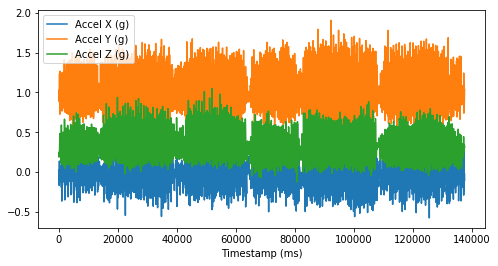

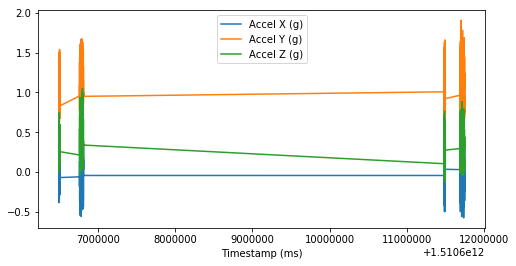

In [163]:
# test function for HC02 walking sacrum accel data
test1 = subj_accel_data(act_dict,'WALKING',location='sacrum')

# merged trials vs non-merged trials
test1.plot(figsize=(8,4))
rawdata.plot(figsize=(8,4))

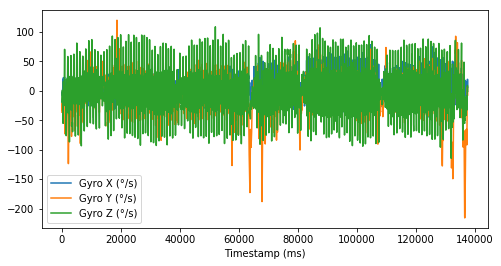

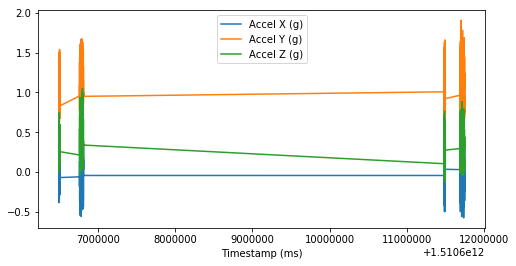

In [164]:
# test function for HC02 walking sacrum gyro data
test2 = subj_gyro_data(act_dict,'WALKING',location='sacrum')

# merged trials vs non-merged trials
test2.plot(figsize=(8,4))
rawdata.plot(figsize=(8,4))

### Need to modify function to not append gyro after accel data

In [154]:
def merged_trials(act_dict,task,location):
    
    merged_data = pd.DataFrame()
    #merged_data = {}
    #data = pd.DataFrame()
    
    for trial in act_dict[task].keys():
        
        for s in ['gyro']: #,'gyro']:
            rawdata = act_dict[task][trial][location][s]
            
            #####################
            # create a filter to cut out empty parts
            #####################
            
            #reindex time (relative to start)
            idx = rawdata.index
            if merged_data.empty is True:
                idx = idx - idx[0]
            else:
                idx = idx - idx[0] + 32 + merged_data.index[-1]
            rawdata.index = idx
            
            #append subsequent trial data
            merged_data = merged_data.append(rawdata)
            #merged_data[s] = merged_data.append(rawdata)
            #data.append(rawdata)
            #merged_data[s] = data
    
    return merged_data

In [155]:
# test function
test2 = merged_trials(act_dict,'WALKING',location='sacrum')

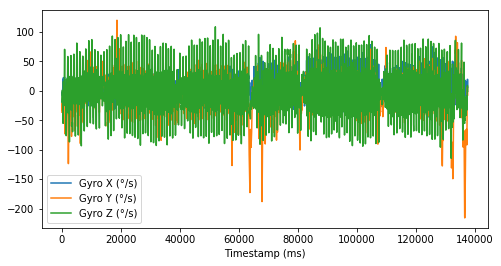

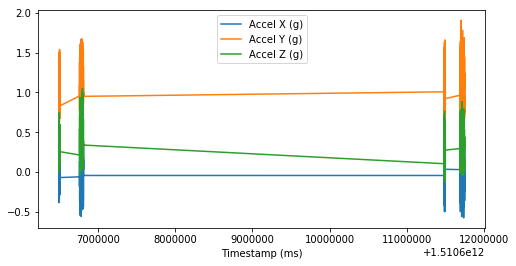

In [156]:
# merged trials vs non-merged trials
test2.plot(figsize=(8,4))
rawdata.plot(figsize=(8,4))

In [134]:
test2

{'accel': Empty DataFrame
 Columns: []
 Index: [], 'gyro': Empty DataFrame
 Columns: []
 Index: []}

In [ ]:
# test
testdata = one_trial(act_dict,task='WALKING',location='sacrum')
# shape should be (4295, 3)
testdata.shape
#clip_data[3]['accel']

In [ ]:
#HCO2 walking sacrum accel - all trials
# 4295x3

In [ ]:
rawdata = clip_data
rawdata.plot(figsize=(8,4))

In [ ]:
# Extract clips
clip_data = gen_clips(act_dict,task,loc,verbose=True,len_tol=0.95)
feature_extraction(clip_data)